In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader,Dataset,random_split
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torch.optim as optim
import torchvision.models as models

import sklearn
from sklearn.metrics import cohen_kappa_score,accuracy_score

import time
from tqdm import tqdm_notebook

import os
print(os.listdir("../input"))
base_dir = "../input/aptos2019-blindness-detection/"

['aptos2019-blindness-detection']


reading the training and test csv files so as to determine which image belongs to which 

In [2]:
train_csv=pd.read_csv("../input/aptos2019-blindness-detection/train.csv")
test_csv=pd.read_csv("../input/aptos2019-blindness-detection/test.csv")

In [3]:
print(len(train_csv),len(test_csv))

3662 1928


In [4]:
train_csv.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [5]:
test_csv.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


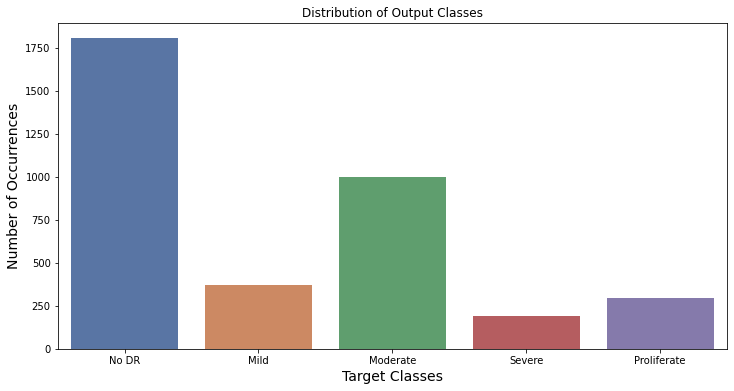

In [29]:
# visualizing class distribution 

counts=train_csv['diagnosis'].value_counts()
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']
for i,x in enumerate(class_list):
    counts[x] = counts.pop(i)
    
plt.figure(figsize=(12,6))
sns.barplot(counts.index, counts.values, alpha=1, palette='deep')
plt.title('Distribution of Output Classes')
plt.ylabel('Number of Occurrences', fontsize=14)
plt.xlabel('Target Classes', fontsize=14)
plt.show()

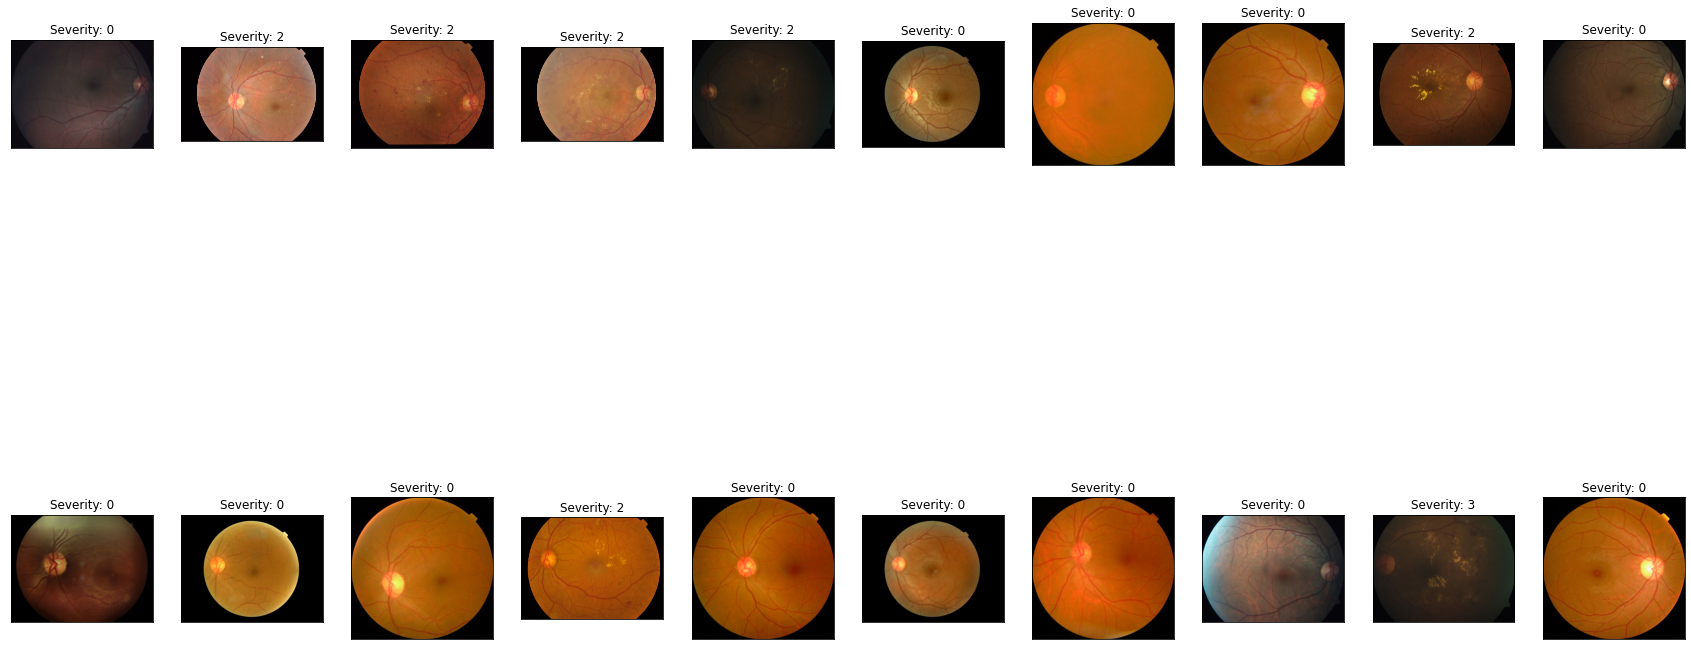

In [30]:
# visualizing some training images

fig = plt.figure(figsize=(30, 16))
# display 20 images
train_imgs = os.listdir(base_dir+"/train_images")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/train_images/" + img)
    plt.imshow(im)
    lab = train_csv.loc[train_csv['id_code'] == img.split('.')[0], 'diagnosis'].values[0]
    ax.set_title('Severity: %s'%lab)

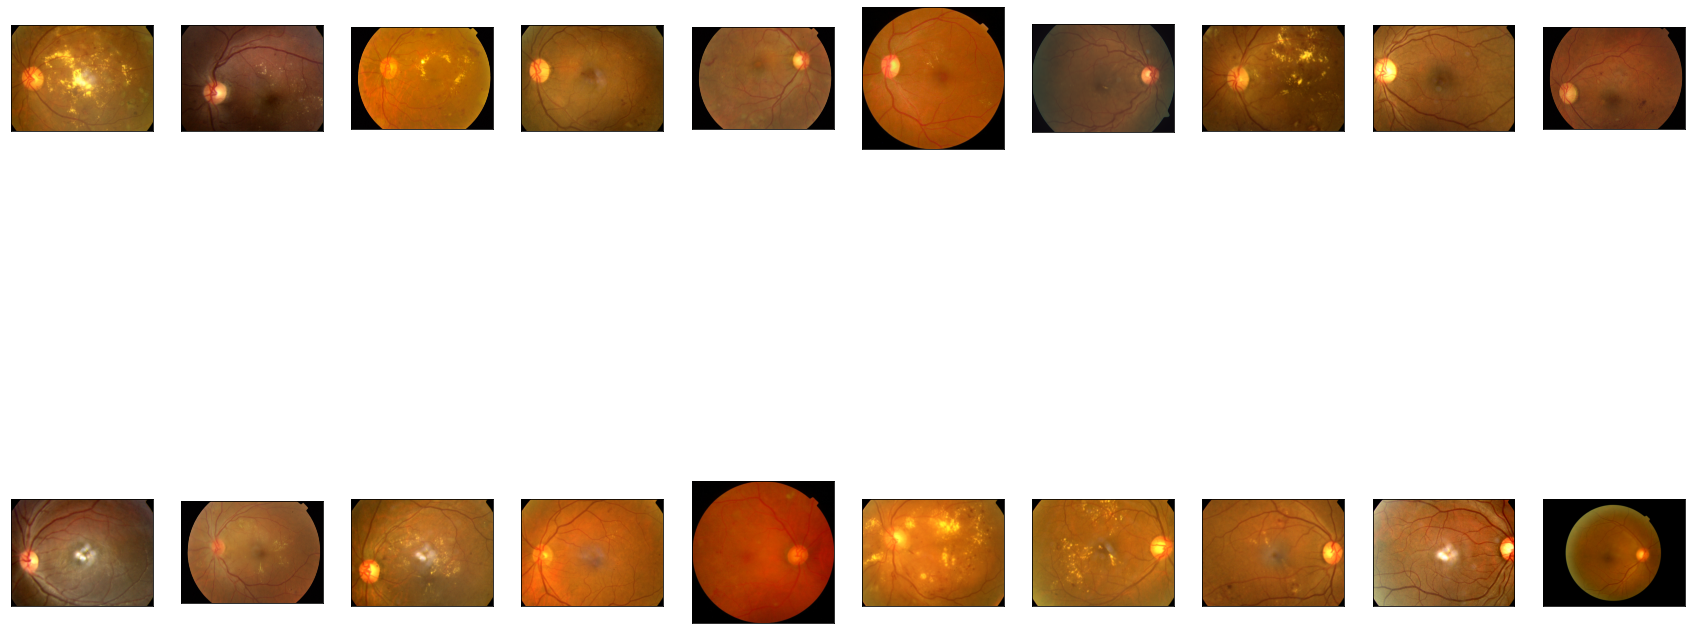

In [31]:
# visualizing test images

fig = plt.figure(figsize=(30, 16))
# display 20 images
test_imgs = os.listdir(base_dir+"/test_images")
for idx, img in enumerate(np.random.choice(test_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/test_images/" + img)
    plt.imshow(im)

In [9]:
# creating a dataset class to prepare dataset from given images path ; Dataset as parent class
class CreateDataset(Dataset):
    # the init method or the constructor method 
    def __init__(self,df_data,data_dir='../input/',transform=None):
        
        # the super() method dynamically represents the base class and super().__init__() calls the init method of base class 
        super().__init__()
        self.df=df_data.values
        self.data_dir=data_dir
        self.transform=transform
        
    # gives the length when len(instance) is called
    def __len__(self):
        return len(self.df)
    
    # getitem is used for extracting the instances attributes; generally used with lists , tuples
    def __getitem__(self,index):
        img_name,label=self.df[index]
        img_path=os.path.join(self.data_dir,img_name+'.png')
        image=cv2.imread(img_path)
        
        if self.transform is not None:
            image=self.transform(image)
            
        return image,label

In [10]:
# transformations for images
transforms = transforms.Compose([
    transforms.ToPILImage(mode='RGB'),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [11]:
train_path="../input/aptos2019-blindness-detection/train_images"
test_path="../input/aptos2019-blindness-detection/test_images"

In [12]:
train_data=CreateDataset(df_data=train_csv,data_dir=train_path,transform=transforms)


In [13]:
batch_size=32
valid_size=0.15
train_size=1-valid_size
num_train=len(train_data)
split=int(np.floor(valid_size*num_train))

# For subset sampling 
# indices=list(range(num_train))
# split=int(np.floor(valid_size*num_train))
# train_idx,valid_idx=indices[split:],indices[:split]

# train_sampler=SubsetRandomSampler(train_idx)
# valid_sampler=SubsetRandomSampler(valid_idx)

# using random_split()
train_dataset, val_dataset = random_split(train_data, (num_train-split,split))

train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
valid_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=True)

In [14]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        images, labels = images.cuda(), labels.cuda()
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        images, labels = images.cuda(), labels.cuda()
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [15]:
class aptos_model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        model=models.resnet152(pretrained=True)
        model.avg_pool=nn.AdaptiveAvgPool2d(output_size=(1,1))
        model.fc=nn.Sequential(
                    nn.Linear(in_features=2048,out_features=1024,bias=True),
                    nn.ReLU(),
                    nn.Linear(in_features=1024, out_features=512, bias=True),
                    nn.ReLU(),
                    nn.Linear(in_features=512, out_features=256, bias=True),
                    nn.ReLU(),
                    nn.Linear(in_features=256, out_features=128, bias=True),
                    nn.ReLU(),
                    nn.Linear(in_features=128, out_features=32, bias=True),
                    nn.ReLU(),
                    nn.Linear(in_features=32, out_features=5, bias=True),
        )
        self.network = model
        
    def forward(self, xb):
        return self.network(xb)

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda:0')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [18]:
model=aptos_model()
model=model.cuda()

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [19]:
@torch.no_grad() # this function disables thee gradient calculation
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in tqdm_notebook(val_loader)]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm_notebook(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward() # this step calculated all gradients 
            optimizer.step() # this steps updates the weights 
            optimizer.zero_grad() # this steps clears the gradients 
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.001

In [21]:
history = fit(num_epochs, lr, model, train_loader, valid_loader, opt_func)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/98 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.0299, val_loss: 0.9821, val_acc: 0.6462


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.8598, val_loss: 2.0870, val_acc: 0.5049


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.8130, val_loss: 0.8194, val_acc: 0.7222


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.8099, val_loss: 0.8379, val_acc: 0.7139


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.7593, val_loss: 0.7677, val_acc: 0.7181


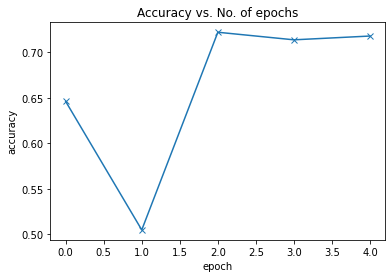

In [22]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

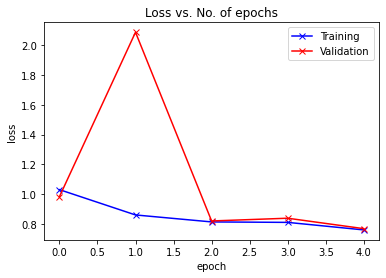

In [23]:
train_losses = [x.get('train_loss') for x in history]
val_losses = [x['val_loss'] for x in history]
plt.plot(train_losses, '-bx')
plt.plot(val_losses, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs');

In [24]:
# creating a dataset class to prepare dataset from given images path ; Dataset as parent class
class CreateTestDataset(Dataset):
    # the init method or the constructor method 
    def __init__(self,df_data,data_dir='../input/',transform=None):
        
        # the super() method dynamically represents the base class and super().__init__() calls the init method of base class 
        super().__init__()
        self.df=df_data.values
        self.data_dir=data_dir
        self.transform=transform
        
    # gives the length when len(instance) is called
    def __len__(self):
        return len(self.df)
    
    # getitem is used for extracting the instances attributes; generally used with lists , tuples
    def __getitem__(self,index):
        img_name=self.df[index][0]
        img_path=os.path.join(self.data_dir,img_name+'.png')
        image=cv2.imread(img_path)
        
        if self.transform is not None:
            image=self.transform(image)
            
        return image

In [25]:
test_data=CreateTestDataset(df_data=test_csv,data_dir=test_path,transform=transforms)
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=True)

In [26]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']
    return class_list[preds[0].item()]

Predicted: Moderate


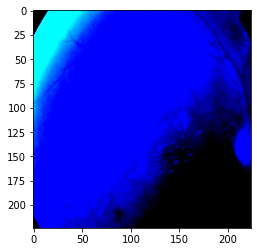

In [27]:
img= test_data[0]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model))

In [28]:
#The .state_dict method returns an OrderedDict containing all the weights and bias matrices mapped to the right attributes of the model.
#To load the model weights, we can redefine the model with the same structure, and use the .load_state_dict method.
torch.save(model.state_dict(), 'aptos-cnn.pth')
model.load_state_dict(torch.load('aptos-cnn.pth'))

<All keys matched successfully>